## Final Assignment Overview: Working with Patient Records and Encounter Notes

In this final assignment, we’ll focus on patient records related to COVID-19 encounters. Our task is to analyze, process, and transform the data while applying the concepts we’ve covered throughout this course. Here's a detailed breakdown of the assignment:

What Are Encounter Notes?
An encounter note is a record that captures details about a patient’s visit with a doctor. It includes both structured and semi-structured information that is crucial for understanding the context of the visit. Here’s what an encounter note typically looks like:

```
AMBULATORY ENCOUNTER NOTE
Date of Service: March 2, 2020 15:45-16:30

DEMOGRAPHICS:
Name: Jeffrey Greenfelder
DOB: 1/16/2005
Gender: Male
Address: 428 Wiza Glen Unit 91, Springfield, Massachusetts 01104
Insurance: Guardian
MRN: 055ae6fc-7e18-4a39-8058-64082ca6d515

PERTINENT MEDICAL HISTORY:
- Obesity 

Recent Visit: Well child visit (2/23/2020)
Immunizations: Influenza vaccine (2/23/2020)

Recent Baseline (2/23/2020):
Height: 155.0 cm
Weight: 81.2 kg
BMI: 33.8 kg/m² (99.1th percentile)
BP: 123/80 mmHg
HR: 92/min
RR: 13/min

SUBJECTIVE:
Adolescent patient presents with multiple symptoms including:
- Cough
- Sore throat
- Severe fatigue
- Muscle pain
- Joint pain
- Fever
Never smoker. Symptoms began recently.

OBJECTIVE:
Vitals:
Temperature: 39.3°C (102.7°F)
Heart Rate: 131.1/min
Blood Pressure: 120/73 mmHg
Respiratory Rate: 27.6/min
O2 Saturation: 75.8% on room air
Weight: 81.2 kg

Laboratory/Testing:
Comprehensive Respiratory Panel:
- Influenza A RNA: Negative
- Influenza B RNA: Negative
- RSV RNA: Negative
- Parainfluenza virus 1,2,3 RNA: Negative
- Rhinovirus RNA: Negative
- Human metapneumovirus RNA: Negative
- Adenovirus DNA: Negative
- SARS-CoV-2 RNA: Positive

ASSESSMENT:
1. Suspected COVID-19 with severe symptoms
2. Severe hypoxemia requiring immediate intervention
3. Tachycardia (HR 131)
4. High-grade fever
5. Risk factors:
   - Obesity (BMI 33.8)
   - Adolescent age

PLAN:
1. Face mask provided for immediate oxygen support
2. Infectious disease care plan initiated
3. Close monitoring required due to:
   - Severe hypoxemia
   - Tachycardia
   - Age and obesity risk factors
4. Parent/patient education on:
   - Home isolation protocols
   - Warning signs requiring emergency care
   - Return precautions
5. Follow-up plan:
   - Daily monitoring during acute phase
   - Virtual check-ins as needed

Encounter Duration: 45 minutes
Encounter Type: Ambulatory
Provider: ID# e2c226c2-3e1e-3d0b-b997-ce9544c10528
Facility: 5103c940-0c08-392f-95cd-446e0cea042a
```


The enocuter contains

* General encounter information: 

  * When the encounter took place: Date and time of the visit.
  * Demographics: Patient’s age, gender, and unique medical record identifier.
  * Encounter details: The reason for the visit, diagnosis, and any associated costs.


* Semi-Structured Notes:

These notes mirror how doctors organize their thoughts and observations during an encounter. They generally follow a SOAP format:

* Subjective: The patient’s subjective description of their symptoms, feelings, and medical concerns.
* Objective: The doctor’s objective findings, including test results, measurements, or physical examination outcomes.
* Assessment: The doctor’s evaluation or diagnosis based on subjective and objective information.
* Plan: The proposed treatment plan, including medications, follow-ups, or other interventions.

While some encounter notes might include additional details, the majority conform to this semi-structured format, making them ideal for analysis and transformation.

* Goals for the Assignment

1. Transforming Encounter Notes:

Using an LLM to convert semi-structured encounter notes into a JSON format that organizes the information into structured fields. The JSON will include details such as demographics, encounter specifics, and the SOAP components of the note. Subsequently, you will need to transform the JSON data into a Parquet file, which is not only suitable for analysis in Spark but also ideal for storage later.
Here we will use the ML classificaition to assing the objective and assessment semi-structured fields into standardized, structured fields. The medical taxonomy for this task will be the one provided by the CDC, which defines standard codes for diagnoses, symptoms, procedures, and treatments. This step ensures the structured data aligns with domain-wide medical standards, making it interoperable and ready for deeper analysis.

The JSON format should capture the hierachies described in the structure below. 




2. Basic Analytics and Visualizations:
Using Apache Spark, perform comprehensive data analysis on the encounter data and create visualizations that reveal meaningful patterns. Your analysis must include:
- COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])
- Cumulative case count of Covid between the earliest case observed in the dataset and last case observed
- Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.
- Rank medications by frequency of prescription
- Analyze medication patterns across different demographic groups (e.g., top 3 per age group)
- Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset. 
- An independent group analysis: You need to develop and execute THREE original analyses that provide meaningful insights about COVID-19 patterns in this dataset. For each analysis:
  - Clearly state your analytical question/hypothesis
  - Justify why this analysis is valuable
  - Show your Spark code and methodology
  - Present results with appropriate visualizations


## Part 2 - Basic Analytics and Visualizations

### Read in and set schema for json output

In [0]:
import json

In [0]:
dbutils.fs.cp("dbfs:/FileStore/tables/parsed_notes.jsonl", "file:///tmp/parsed_notes.jsonl")

True

In [0]:
# Read the JSONL file into a list of JSON objects
json_data = [json.loads(line) for line in open('/tmp/parsed_notes.jsonl', 'r')]

print("JSON data loaded successfully.")

JSON data loaded successfully.


In [0]:
#json_data[0]

Set schema for json object

In [0]:
from typing import List, Optional
from pydantic import BaseModel
from datetime import date


class EncounterType(BaseModel):
    code: str
    description: str


class Encounter(BaseModel):
    date: str
    time: str
    provider_id: str
    facility_id: str


class Address(BaseModel):
    city: str
    state: str


class Demographics(BaseModel):
    name: str
    date_of_birth: str
    age: int
    gender: str
    address: Address
    insurance: str


class Condition(BaseModel):
    code: str
    description: str


class Medication(BaseModel):
    code: str
    description: str


class Immunization(BaseModel):
    code: str
    description: str
    date: str


class VitalMeasurement(BaseModel):
    code: str
    value: float
    unit: str


class BloodPressure(BaseModel):
    systolic: Optional[VitalMeasurement]
    diastolic: Optional[VitalMeasurement]


class CurrentVitals(BaseModel):
    temperature: Optional[VitalMeasurement] = None
    heart_rate: Optional[VitalMeasurement] = None
    blood_pressure: Optional[BloodPressure] = None
    respiratory_rate: Optional[VitalMeasurement] = None
    oxygen_saturation: Optional[VitalMeasurement] = None
    weight: Optional[VitalMeasurement] = None


class BaselineVitals(BaseModel):
    date: str
    height: Optional[VitalMeasurement] = None
    weight: Optional[VitalMeasurement] = None
    bmi: Optional[VitalMeasurement] = None
    bmi_percentile: Optional[VitalMeasurement] = None


class Vitals(BaseModel):
    current: Optional[CurrentVitals]
    baseline: Optional[BaselineVitals]


class RespiratoryTest(BaseModel):
    code: str
    result: str


class RespiratoryPanel(BaseModel):
    influenza_a: Optional[RespiratoryTest] = None
    influenza_b: Optional[RespiratoryTest] = None
    rsv: Optional[RespiratoryTest] = None
    parainfluenza_1: Optional[RespiratoryTest] = None
    parainfluenza_2: Optional[RespiratoryTest] = None
    parainfluenza_3: Optional[RespiratoryTest] = None
    rhinovirus: Optional[RespiratoryTest] = None
    metapneumovirus: Optional[RespiratoryTest] = None
    adenovirus: Optional[RespiratoryTest] = None


class Covid19Test(BaseModel):
    code: str
    description: str
    result: str


class Laboratory(BaseModel):
    covid19: Optional[Covid19Test] = None
    respiratory_panel: Optional[RespiratoryPanel] = None


class Procedure(BaseModel):
    code: str
    description: str
    date: str
    reasonCode: str
    reasonDescription: str


class CarePlan(BaseModel):
    code: str
    description: str
    start: str
    stop: str
    reasonCode: str
    reasonDescription: str


class PatientRecord(BaseModel):
    demographics: Demographics
    encounter: Optional[Encounter] = None
    conditions: Optional[List[Condition]] = None
    medications: Optional[List[Medication]] = None
    immunizations: Optional[List[Immunization]] = None
    vitals: Optional[Vitals] = None
    laboratory: Optional[Laboratory] = None
    procedures: Optional[List[Procedure]] = None


In [0]:
import json
from typing import List
import pandas as pd
from pydantic import ValidationError

In [0]:
def flatten_patient_data(record: PatientRecord):
    flat_data = {
        "name": record.demographics.name,
        "date_of_birth": record.demographics.date_of_birth,
        "age": record.demographics.age,
        "gender": record.demographics.gender,
        "city": record.demographics.address.city,
        "state": record.demographics.address.state,
        "insurance": record.demographics.insurance,
        "encounter_date": record.encounter.date if record.encounter else None,
        "encounter_time": record.encounter.time if record.encounter else None,
        "provider_id": record.encounter.provider_id if record.encounter else None,
        "facility_id": record.encounter.facility_id if record.encounter else None,
        "conditions": [cond.description for cond in record.conditions] if record.conditions else None,
        "medications": [med.description for med in record.medications] if record.medications else None,
        "temperature": record.vitals.current.temperature.value if record.vitals and record.vitals.current and record.vitals.current.temperature else None,
        "covid_test_result": record.laboratory.covid19.result if record.laboratory and record.laboratory.covid19 else None,
        "procedures": [proc.description for proc in record.procedures] if record.procedures else None,
    }
    return flat_data

In [0]:
import json
from pydantic import ValidationError

# Step 1: Read the JSONL file and parse each line
patient_records = []

with open('/tmp/parsed_notes.jsonl', 'r') as f:
    for line in f:
        line = line.strip()  # Remove whitespace and newline
        if not line:
            continue

        try:
            # Parse the JSON string into a dictionary
            json_data = json.loads(line)
            
            # Step 2: Convert the JSON data to a Pydantic PatientRecord instance
            patient_record = PatientRecord(**json_data)
            
            # Flatten data to prepare it for a Pandas DataFrame
            flat_data = flatten_patient_data(patient_record)
            patient_records.append(flat_data)

        except ValidationError as e:
            print(f"Validation Error for a record: {e}")

# Step 3: Convert to a Pandas DataFrame and save it to a Parquet file
import pandas as pd

df = pd.DataFrame(patient_records)
df.to_parquet("///tmp/patient_record.parquet", index=False)

print("Data successfully saved to Parquet")


Data successfully saved to Parquet


In [0]:
df.head(2)

,name,date_of_birth,age,gender,city,state,insurance,encounter_date,encounter_time,provider_id,facility_id,conditions,medications,temperature,covid_test_result,procedures
0,Elmer Schinner,1993-06-16,31,M,Boston,Massachusetts,Self,2020-03-18,21:03:20,b8a245a1-de55-3ff1-ad90-633d8411c1c5,3278c48a-aff0-3325-ba4a-5bb3eae5304c,"[Cough (finding), Dyspnea (finding), Wheezing ...",[0.4 ML Enoxaparin sodium 100 MG/ML Prefilled ...,38.1,Detected (qualifier value),"[Face mask (physical object), Plain chest X-ra..."
1,Albert Kshleri,2013-05-31,11,M,Chelsea,Massachusetts,Self,2020-05-22,20:59:35,2c6b08cf-0e34-37bf-9447-2823cc00073e,2a4518d8-7014-3404-b2e9-1c30c76b6a12,"[Cough (finding), Dyspnea (finding), Wheezing ...",None,39.2,Detected (qualifier value),[Face mask (physical object)]


In [0]:
dbutils.fs.cp("file:///tmp/patient_record.parquet", "dbfs:/FileStore/tables/patient_record.parquet")

True

## Analysis

In [0]:
# Load data from the Parquet file
parquet_df = spark.read.parquet('dbfs:/FileStore/tables/patient_record.parquet')

# Show the first few rows
parquet_df.show(2)


+--------------+-------------+---+------+-------+-------------+---------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+
|          name|date_of_birth|age|gender|   city|        state|insurance|encounter_date|encounter_time|         provider_id|         facility_id|          conditions|         medications|temperature|   covid_test_result|          procedures|
+--------------+-------------+---+------+-------+-------------+---------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+
|Elmer Schinner|   1993-06-16| 31|     M| Boston|Massachusetts|     Self|    2020-03-18|      21:03:20|b8a245a1-de55-3ff...|3278c48a-aff0-332...|[Cough (finding),...|[0.4 ML Enoxapari...|       38.1|Detected (qualifi...|[Face mask (physi...|
|Albert Kshleri|   2013-05-31| 1

### COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])

In [0]:
from pyspark.sql.functions import col, when

# Categorize age into predefined age ranges
parquet_df = parquet_df.withColumn(
    "age_range",
    when(col("age") <= 5, "[0-5]")
    .when(col("age") <= 10, "[6-10]")
    .when(col("age") <= 17, "[11-17]")
    .when(col("age") <= 30, "[18-30]")
    .when(col("age") <= 50, "[31-50]")
    .when(col("age") <= 70, "[51-70]")
    .otherwise("[71+]")
)

In [0]:
# Count the number of cases for each age range
age_counts = (
    parquet_df.groupBy("age_range")
    .count()
    .orderBy("age_range")
)

# Show the results
age_counts.show()

+---------+-----+
|age_range|count|
+---------+-----+
|    [0-5]|   25|
|  [11-17]|  126|
|  [18-30]|  320|
|  [31-50]|  436|
|  [51-70]|  508|
|   [6-10]|   95|
|    [71+]|  489|
+---------+-----+



### Cumulative case count of Covid between the earliest case observed in the dataset and last case observed

In [0]:
results = parquet_df.select("covid_test_result").distinct().collect()
results

[Row(covid_test_result=None),
 Row(covid_test_result='Not detected (qualifier value)'),
 Row(covid_test_result='Detected (qualifier value)')]

In [0]:
positives = parquet_df.select("covid_test_result").where(parquet_df.covid_test_result == "Detected (qualifier value)")
print(f'The cumlative case count of Covid is {positives.count()}')

The cumlative case count of Covid is 1172


### Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID. (ignore this question)

### Rank medications by frequency of prescription

In [0]:
medications = parquet_df.select("medications")
example = medications.take(1)
example

[Row(medications=['0.4 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe', 'NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler', 'Acetaminophen 500 MG Oral Tablet', '1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe'])]

Because the medications are in a list, we will explode the column so that there is one row for each medication

In [0]:
from pyspark.sql.functions import explode
exploded_df = parquet_df.withColumn("medication", explode(col("medications")))
exploded_df.select("medication").show(5)

+--------------------+
|          medication|
+--------------------+
|0.4 ML Enoxaparin...|
|NDA020503 200 ACT...|
|Acetaminophen 500...|
|1 ML Enoxaparin s...|
|0.4 ML Enoxaparin...|
+--------------------+
only showing top 5 rows



Now we can count up the frequency of each medication

In [0]:
from pyspark.sql.functions import col

medication_counts = exploded_df.groupBy("medication").count()
medication_counts_sorted = medication_counts.orderBy(col("count").desc())
medication_counts_sorted.show(10)

+--------------------+-----+
|          medication|count|
+--------------------+-----+
|Acetaminophen 500...|  302|
|0.4 ML Enoxaparin...|  291|
|1 ML Epoetin Alfa...|  214|
|1 ML Enoxaparin s...|  174|
|NDA020503 200 ACT...|  165|
|insulin human  is...|   88|
|Simvastatin 10 MG...|   83|
|Hydrochlorothiazi...|   82|
|24 HR Metformin h...|   69|
|amLODIPine 5 MG /...|   52|
+--------------------+-----+
only showing top 10 rows



### Analyze medication patterns across different demographic groups (e.g., top 3 per age group)


Since we already created an age croup column in an above question, we can use this to get the top 3 medications per age group.

In [0]:
medications_in_groups = exploded_df.groupBy("age_range", "medication").count()
medications_in_groups.show(5)

+---------+--------------------+-----+
|age_range|          medication|count|
+---------+--------------------+-----+
|   [6-10]|cetirizine hydroc...|    2|
|   [6-10]|Clopidogrel 75 MG...|    1|
|    [71+]|amLODIPine 5 MG /...|   13|
|  [51-70]|Mirena 52 MG Intr...|    2|
|  [51-70]|Amlodipine 5 MG O...|    8|
+---------+--------------------+-----+
only showing top 5 rows



Now we can create partitions over each age_range and then use a window to order each partition by count. Then we can extract the top 3 medications by frequency for each age group.

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

# Define the window with partitionsby age_range and ordered by count
window = Window.partitionBy("age_range").orderBy(col("count").desc())

# add row_number column
medication_age_range = medications_in_groups.withColumn("row_number", row_number().over(window))

# Filter to keep only rows with row_number <= 3
top_3_medications_per_age_range = medication_age_range.filter(col("row_number") <= 3)

# Show the results
top_3_medications_per_age_range.show(12)


+---------+--------------------+-----+----------+
|age_range|          medication|count|row_number|
+---------+--------------------+-----+----------+
|    [0-5]|Ibuprofen 100 MG ...|    3|         1|
|    [0-5]|1 ML Enoxaparin s...|    1|         2|
|    [0-5]|Acetaminophen 21....|    1|         3|
|  [11-17]|NDA020503 200 ACT...|   14|         1|
|  [11-17]|120 ACTUAT Flutic...|   11|         2|
|  [11-17]|Acetaminophen 500...|    9|         3|
|  [18-30]|Acetaminophen 500...|   35|         1|
|  [18-30]|0.4 ML Enoxaparin...|   34|         2|
|  [18-30]|1 ML Enoxaparin s...|   21|         3|
|  [31-50]|Acetaminophen 500...|   63|         1|
|  [31-50]|0.4 ML Enoxaparin...|   62|         2|
|  [31-50]|NDA020503 200 ACT...|   32|         3|
+---------+--------------------+-----+----------+
only showing top 12 rows




We use row_number since this ensure no ties in the ranking and no skipping of rank. That means for ties, I elected to leave it up to chance on which medicine gets the spot

### Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset.

We can print a row to find the field that will give us co-morbidity information

In [0]:
import json 

row = parquet_df.take(2)

row_dict = [r.asDict() for r in row]

# print the json
print(json.dumps(row_dict, indent=4))

[
    {
        "name": "Elmer Schinner",
        "date_of_birth": "1993-06-16",
        "age": 31,
        "gender": "M",
        "city": "Boston",
        "state": "Massachusetts",
        "insurance": "Self",
        "encounter_date": "2020-03-18",
        "encounter_time": "21:03:20",
        "provider_id": "b8a245a1-de55-3ff1-ad90-633d8411c1c5",
        "facility_id": "3278c48a-aff0-3325-ba4a-5bb3eae5304c",
        "conditions": [
            "Cough (finding)",
            "Dyspnea (finding)",
            "Wheezing (finding)",
            "Diarrhea symptom (finding)",
            "Fever (finding)",
            "Loss of taste (finding)",
            "Suspected COVID-19",
            "COVID-19",
            "Pneumonia (disorder)",
            "Hypoxemia (disorder)",
            "Respiratory distress (finding)",
            "Acute respiratory failure (disorder)",
            "Sepsis caused by virus (disorder)",
            "Acute pulmonary embolism (disorder)"
        ],
        "med

It looks like we can access co-morbidity information from the conditions column. Lets try to find people that have co-mobidity between hypertension, obesity, and pre-diabetes. 

In [0]:
from pyspark.sql.functions import col, array_contains, expr

# Conditions to match
conditions_to_match = ["COVID-19", "Pneumonia (disorder)"]

# Dynamic version for variable-length conditions_to_match:
"""
# Create a filter expression to check if any of the conditions are in the conditions column
# array contians is a PySpark function that checks if a specific value exists in an array column
filter_expr = " OR ".join([f"array_contains(conditions, '{condition}')" for condition in conditions_to_match])

# Filter the DataFrame
matching_conditions_df = parquet_df.filter(expr(filter_expr))
"""

matching_conditions_df = parquet_df.filter("array_contains(conditions, 'COVID-19') AND array_contains(conditions, 'Pneumonia (disorder)')")

# count number of results
matching_conditions_df.count()

302

Let's see the distribution of co-morbidity by age group

First let's get the counts by each age group that has the co-morbidities

In [0]:
co_morbidity_age_group = matching_conditions_df.groupBy("age_range").count() \
  .orderBy("age_range")
count_info = co_morbidity_age_group.collect()
count_info

[Row(age_range='[0-5]', count=1),
 Row(age_range='[11-17]', count=9),
 Row(age_range='[18-30]', count=35),
 Row(age_range='[31-50]', count=63),
 Row(age_range='[51-70]', count=119),
 Row(age_range='[6-10]', count=4),
 Row(age_range='[71+]', count=71)]

Now lets get the total counts to calculate the proportion of all patients in the age_range with the co-morbidity

In [0]:
total_counts_by_age_group = parquet_df.groupBy("age_range").count() \
  .orderBy("age_range")
total_count_info = total_counts_by_age_group.collect()
total_count_info

[Row(age_range='[0-5]', count=25),
 Row(age_range='[11-17]', count=126),
 Row(age_range='[18-30]', count=320),
 Row(age_range='[31-50]', count=436),
 Row(age_range='[51-70]', count=508),
 Row(age_range='[6-10]', count=95),
 Row(age_range='[71+]', count=489)]

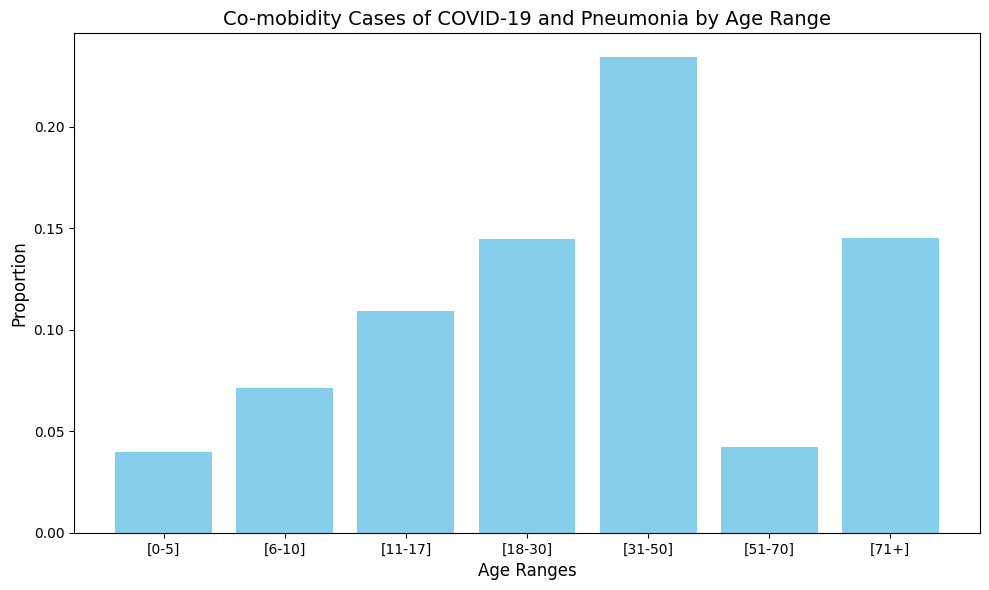

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting age ranges and counts
correct_order = ['[0-5]', '[6-10]', '[11-17]', '[18-30]', '[31-50]', '[51-70]', '[71+]']
co_counts = np.array([row['count'] for row in count_info])
total_counts = np.array([row['count'] for row in total_count_info])

proportions = co_counts / total_counts

plt.figure(figsize=(10, 6))
plt.bar(correct_order, proportions, color='skyblue')

plt.xlabel("Age Ranges", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.title("Co-mobidity Cases of COVID-19 and Pneumonia by Age Range", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

Interestingly, there is a postive trend for the proportion of people with a co-morbidity of COVID-19 and Pneumonia until [31-50]. I would have expected the oldest age group [71+] and the youngest age group [0-5] to have the highest proportion because they usually have weaker immune systems.

Now let's see what the frequencies by themselves are

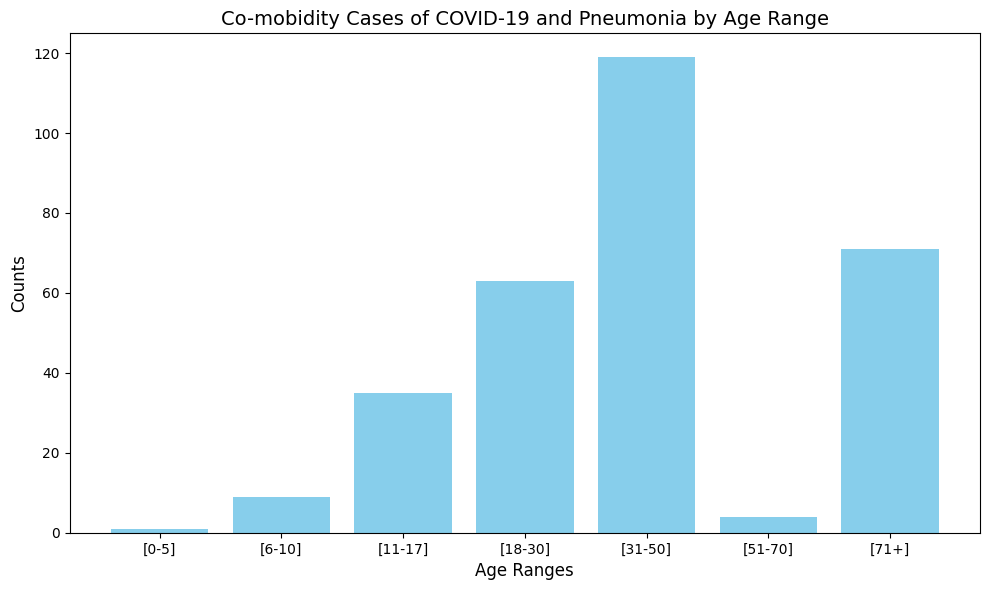

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting age ranges and counts
correct_order = ['[0-5]', '[6-10]', '[11-17]', '[18-30]', '[31-50]', '[51-70]', '[71+]']
co_counts = np.array([row['count'] for row in count_info])

plt.figure(figsize=(10, 6))
plt.bar(correct_order, co_counts, color='skyblue')

plt.xlabel("Age Ranges", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.title("Co-mobidity Cases of COVID-19 and Pneumonia by Age Range", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

This may just reflect the population of the encounter notes instead of actual trends in co-morbidity

## Independent group analysis: 

The independent analysis was done with 
Quang Loc Lam and James Phan

### Hypothesis

My hypothesis is that the people with the co-morbidity of COVID-19 and Pneumonia will have a more intensive procedure. That is, they will have a longer medical procedure than just people with just COVID and no Pneumonia

### Value

The results of this analysis can provide meaningful insight into the difference of care required to treat COVID patients with a co-morbidity vs. COVID patients without. If those with COVID-19 and Pneumonia require a more intensive operation, we need to be especially cautious of exposing at risk people to COVID

### Methodology

- I will create a new column `procedure_length` which represents the length of the `procedure` field in the original dataframe
- I will create a filtered dataframe of those with COVID and pneumonia and those with only COVID.
- I will collect the `procedure_length` lengths of both dataframes and create a plot to display the distribution of both dataframes

Create new column

In [0]:
from pyspark.sql.functions import size, col 

procedure_length = parquet_df.withColumn("procedure_length", size(col("procedures")))
procedure_length.select("procedures", "procedure_length").take(1)

[Row(procedures=['Face mask (physical object)', 'Plain chest X-ray (procedure)', 'Oxygen administration by mask (procedure)', 'Placing subject in prone position (procedure)', 'Oxygen administration by mask (procedure)', 'Placing subject in prone position (procedure)', 'Oxygen administration by mask (procedure)', 'Placing subject in prone position (procedure)', 'Oxygen administration by mask (procedure)', 'Placing subject in prone position (procedure)', 'Oxygen administration by mask (procedure)', 'Placing subject in prone position (procedure)', 'Oxygen administration by mask (procedure)', 'Placing subject in prone position (procedure)', 'Oxygen administration by mask (procedure)', 'Placing subject in prone position (procedure)'], procedure_length=16)]

Create filtered dataframes (Pneumonia and Covid) and (just Covid)

In [0]:
both = procedure_length.filter("array_contains(conditions, 'COVID-19') AND array_contains(conditions, 'Pneumonia (disorder)')")

# count number of results
both.count()

302

In [0]:
only_covid = procedure_length.filter("array_contains(conditions, 'COVID-19') AND NOT array_contains(conditions, 'Pneumonia (disorder)')")

# count number of results
only_covid.count()

1133

Collect procedure lengths from each dataframe

In [0]:
both_counts = both.select("procedure_length").collect()
both_counts_list = [row['procedure_length'] for row in both_counts]
both_counts_list[0:10]

[16, 12, 56, 42, 32, 25, 20, 14, 33, 26]

In [0]:
only_covid_counts = only_covid.select("procedure_length").collect()
only_covid_counts_list = [row['procedure_length'] for row in only_covid_counts]
only_covid_counts_list[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 2]

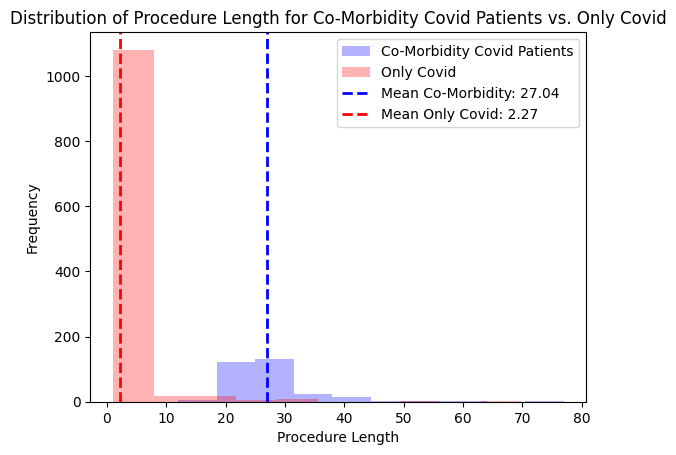

In [0]:
# Create the histogram with different colors
plt.hist(both_counts_list, bins=10, alpha=0.3, color='b', label='Co-Morbidity Covid Patients')
plt.hist(only_covid_counts_list, bins=10, alpha=0.3, color='r', label='Only Covid')

# calculate means
mean_both = np.mean(both_counts_list)
mean_only_covid = np.mean(only_covid_counts_list)

# Add vertical lines at the means
plt.axvline(mean_both, color='b', linestyle='dashed', linewidth=2, label=f'Mean Co-Morbidity: {mean_both:.2f}')
plt.axvline(mean_only_covid, color='r', linestyle='dashed', linewidth=2, label=f'Mean Only Covid: {mean_only_covid:.2f}')

# Add labels and title
plt.xlabel('Procedure Length')
plt.ylabel('Frequency')
plt.title('Distribution of Procedure Length for Co-Morbidity Covid Patients vs. Only Covid')
plt.legend()

# Show the plot
plt.show()

Based on the results, the COVID patients with co-morbidity do have more intensive procedures than those with jsut COVID. Therefore, Pneumonia seems to increase the severity of COVID-19.